In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import Input
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras


2025-09-29 18:42:38.376959: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759171358.564650      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759171358.616398      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
data_path = "/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train"
data_test="/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test"

In [5]:
input_size = (64, 64)   
batch_size = 32
# Augmentation (ImageDataGenerator)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=12,
    width_shift_range=0.08,
    height_shift_range=0.08,
    shear_range=0.08,
    zoom_range=0.08,
    brightness_range=(0.8, 1.2),
    validation_split=0.3,
    fill_mode='nearest'
)

train_gen = train_datagen.flow_from_directory(
    data_path,
    target_size=input_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_gen = train_datagen.flow_from_directory(
    data_path,
    target_size=input_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 60900 images belonging to 29 classes.
Found 26100 images belonging to 29 classes.


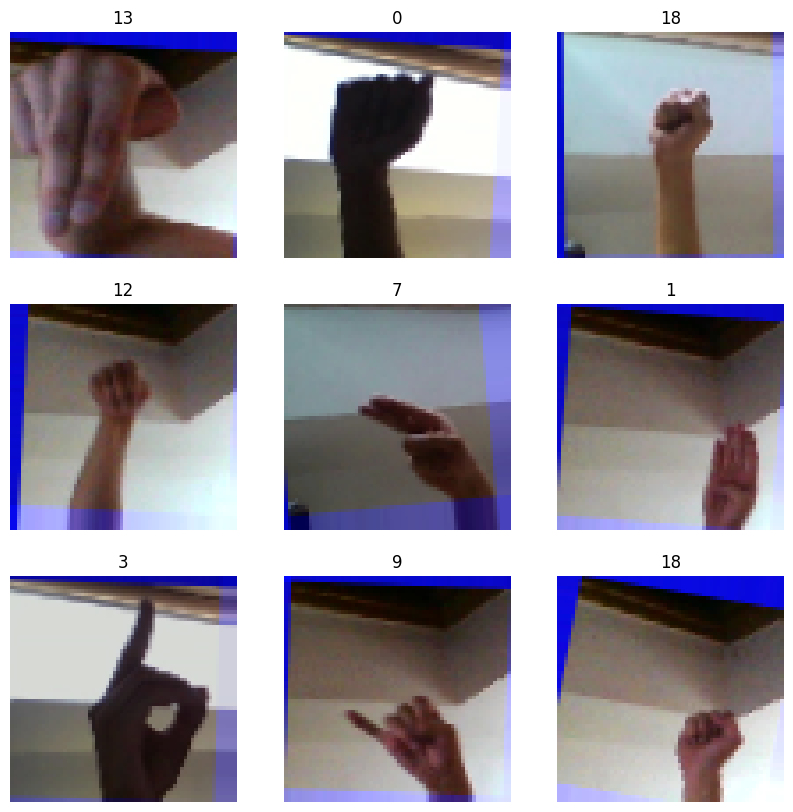

In [6]:
images, labels = next(train_gen)

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(np.argmax(labels[i]))  
    plt.axis("off")
plt.show()


In [16]:
num_classes = len(train_gen.class_indices) 
weight_decay = 1e-4
model = models.Sequential([
    layers.Input(shape=(input_size[0], input_size[1], 3)),
    layers.Conv2D(32, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    
    layers.Conv2D(128, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    layers.Conv2D(256, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 29)             │        14,877 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 538,845 (2.06 MB)

 Trainable params: 536,861 (2.05 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [17]:
model.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [18]:
from tensorflow.keras import callbacks
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=10, restore_best_weights=True, verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7, verbose=1
    ),
    keras.callbacks.ModelCheckpoint(
        'best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1
    )
]


history = model.fit(
    train_gen,
    epochs=20,
    validation_data=val_gen,
    callbacks=callbacks,
    verbose=True
)


Epoch 1/20
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.5236 - loss: 1.7788
Epoch 1: val_accuracy improved from -inf to 0.50333, saving model to best_model.h5
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 508s 262ms/step - accuracy: 0.5237 - loss: 1.7783 - val_accuracy: 0.5033 - val_loss: 2.6957 - learning_rate: 0.0010
Epoch 2/20
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9413 - loss: 0.2853
Epoch 2: val_accuracy improved from 0.50333 to 0.76372, saving model to best_model.h5
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 232s 122ms/step - accuracy: 0.9413 - loss: 0.2853 - val_accuracy: 0.7637 - val_loss: 1.0503 - learning_rate: 0.0010
Epoch 3/20
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9600 - loss: 0.2602
Epoch 3: val_accuracy did not improve from 0.76372
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 211s 111ms/step - accuracy: 0.9600 - loss: 0.2602 - val_accuracy: 0.6941 - val_loss: 1.4816 - learning_rate: 0.0010
Epoch 4/20
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.96

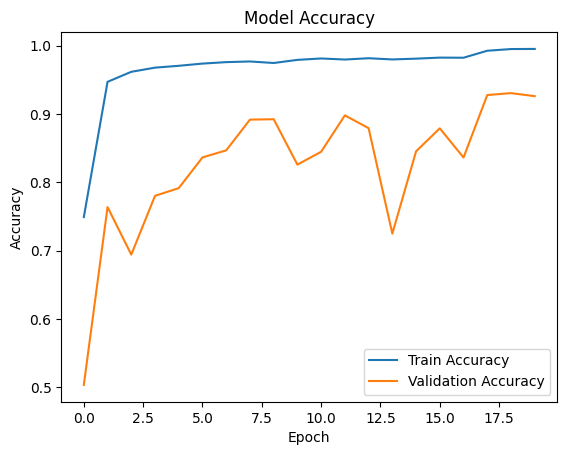

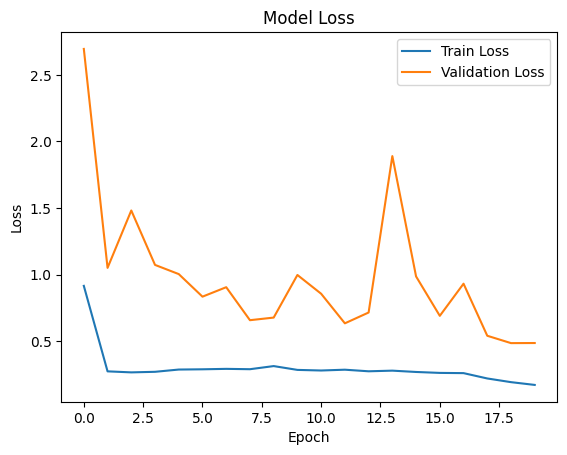

In [19]:
# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [25]:
model.save("asl_model.h5")
